In [1]:
import matplotlib.pyplot as plt

from glob import glob

import numpy as np
import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F

import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import optuna

import wandb

import pickle5 as pickle

from synth_ae import Encoder, Decoder

In [2]:
class SynthDataset(Dataset):
    def __init__(self):
        self.imgs_path = '/data/scratch/bariskurtkaya/synthetic_dataset/synth2_dataset/'
        self.data = []
        
        for img_path in glob(self.imgs_path + '/*.png'):
            if 'exo' in img_path:
                self.data.append([img_path, 'star_exo'])
            else:
                self.data.append([img_path, 'star_only'])
        
        print(self.data[0])
        self.class_map = {'star_only' : 0, 'star_exo': 1}
        #self.img_dim = (28, 28)

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        img_path, class_name = self.data[idx]
        img = cv.imread(img_path, 0)
        
        #noise = np.random.normal(0,10,img.shape)
        #noisy_img = img + noise
                
        #img = cv.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        
        img_tensor = img_tensor.float()
        
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id


In [47]:
dataset = SynthDataset()
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

['/data/scratch/bariskurtkaya/synthetic_dataset/synth2_dataset/trial19118.png', 'star_only']


In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
with open("/data/scratch/bariskurtkaya/synthetic_dataset/synth2_model/150_enc.pickle", "rb") as fin:
    enc_best = pickle.load(fin)
    
with open("/data/scratch/bariskurtkaya/synthetic_dataset/synth2_model/150_dec.pickle", "rb") as fin:
    dec_best = pickle.load(fin)

In [6]:
enc_best = enc_best.to(device)

In [7]:
dec_best = dec_best.to(device)

In [8]:
enc_best, dec_best

(Encoder(
   (layer1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer2): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer3): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer4): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer5): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128,

In [47]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [48]:
test_epoch(enc_best, dec_best, device, train_loader, loss_fn = torch.nn.MSELoss())


torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256,

tensor(801.1661)

In [49]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

enc_best.eval()
dec_best.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = enc_best(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(50, 128)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = dec_best(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:50],10,5))
    plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 1, 1, 28, 28]

In [36]:
img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/trial_exo1.png', 0)
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.float()
img_tensor = img_tensor.view((-1, 160, 160))
img_tensor.shape

torch.Size([1, 160, 160])

In [21]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    #targets = test_dataset.targets.numpy()
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        if i < n/2:
            img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/synth2_dataset/trial{np.random.randint(low=0, high=20000)}.png', 0)
        else:
            img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/synth2_dataset/trial_exo{np.random.randint(low=0, high=10000)}.png', 0)
        noise = np.random.normal(0,150,img.shape)
        img = img + noise
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.float()
        img_tensor = img_tensor.view((-1, 160, 160))
        img_tensor = img_tensor.to(device)
        
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img_tensor))
        plt.imshow(img_tensor.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

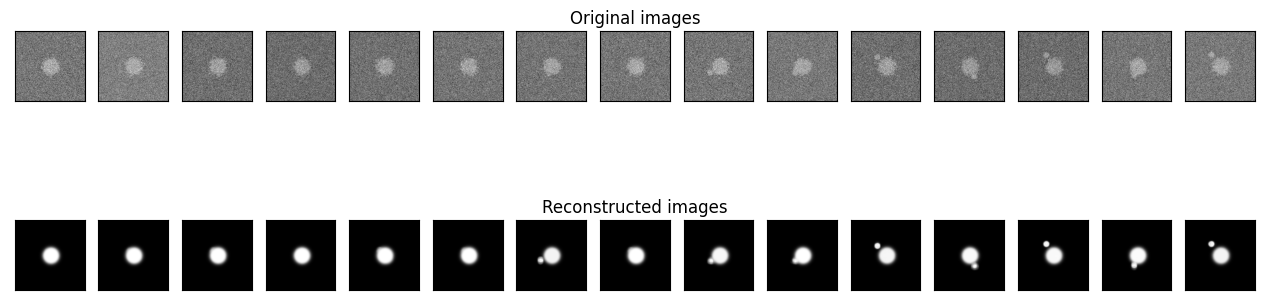

In [22]:
plot_ae_outputs(enc_best,dec_best,n=15)

In [ ]:
dataset = SynthDataset()
train_loader = DataLoader(dataset, batch_size=30000, shuffle=True)

In [48]:
import pandas as pd

test_dataset, labels = next(iter(train_loader))

encoded_samples = []
for idx, sample in tqdm(enumerate(test_dataset)):
    img = sample.unsqueeze(0).to(device)
    label = labels[idx]
    #print(img.shape, label.shape)
    
    # Encode image
    enc_best.eval()
    with torch.no_grad():
        encoded_img  = enc_best(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

0it [00:00, ?it/s]

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0       -238284.093750     1.003055e+06     4.007912e+05   -171227.343750   
1       -772660.500000     3.186776e+06     1.282215e+06   -521708.875000   
2        -15293.566406     7.106436e+04     2.740631e+04    -14367.172852   
3          -335.112152     1.489505e+03     5.546932e+02      -277.397980   
4        -19097.640625     8.846923e+04     3.414956e+04    -17772.728516   
...                ...              ...              ...              ...   
29995    -17382.312500     8.070169e+04     3.112868e+04    -16279.052734   
29996     -3876.703369     2.047328e+04     7.547669e+03     -4874.590332   
29997    -19484.691406     9.015245e+04     3.481371e+04    -18076.240234   
29998    -19470.591797     9.004260e+04     3.477403e+04    -18040.402344   
29999    -17252.144531     8.013525e+04     3.090455e+04    -16177.349609   

       Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0         7.958220e+05    304956.437500    -8.240766e+05     67918.757812   
1         2.525695e+06    982159.375000    -2.581802e+06    195293.218750   
2         5.638489e+04     20248.957031    -6.178566e+04      6707.307129   
3         1.137897e+03       432.482452    -1.240050e+03        96.608452   
4         7.018561e+04     25272.244141    -7.677151e+04      8244.143555   
...                ...              ...              ...              ...   
29995     6.402927e+04     23015.292969    -7.012434e+04      7582.614746   
29996     1.620967e+04      5372.768066    -1.891619e+04      2530.733398   
29997     7.151888e+04     25773.869141    -7.817913e+04      8369.957031   
29998     7.142738e+04     25750.550781    -7.806172e+04      8345.532227   
29999     6.357908e+04     22846.167969    -6.964994e+04      7539.931152   

       Enc. Variable 8  Enc. Variable 9  ...  Enc. Variable 991  \
0        -3.245765e+05     1.119708e+06  ...     -280607.468750   
1        -1.006057e+06     3.549468e+06  ...     -908189.875000   
2        -2.545040e+04     7.962056e+04  ...      -18180.847656   
3        -5.037462e+02     1.591166e+03  ...        -391.207581   
4        -3.157661e+04     9.907233e+04  ...      -22680.078125   
...                ...              ...  ...                ...   
29995    -2.887060e+04     9.040152e+04  ...      -20654.113281   
29996    -8.143283e+03     2.292429e+04  ...       -4648.956055   
29997    -3.213887e+04     1.009480e+05  ...      -23135.931641   
29998    -3.208385e+04     1.008156e+05  ...      -23116.824219   
29999    -2.868093e+04     8.976852e+04  ...      -20501.335938   

       Enc. Variable 992  Enc. Variable 993  Enc. Variable 994  \
0         -159047.859375      -78646.187500      233702.484375   
1         -520759.343750     -262252.343750      754056.437500   
2           -9817.446289       -4142.861816       15266.641602   
3            -245.295532         -75.237274         298.989227   
4          -12325.111328       -5248.679688       19038.191406   
...                  ...                ...                ...   
29995      -11186.541992       -4741.554688       17341.976562   
29996       -2395.831787        -679.110535        3909.392334   
29997      -12584.528320       -5370.589844       19417.492188   
29998      -12581.126953       -5372.328125       19397.484375   
29999      -11099.563477       -4699.552246       17213.689453   

       Enc. Variable 995  Enc. Variable 996  Enc. Variable 997  \
0           6.002440e+05      -9.963554e+05     -197874.375000   
1           1.909872e+06      -3.162084e+06     -647346.812500   
2           4.213662e+04      -7.059077e+04      -12170.349609   
3           8.722164e+02      -1.426972e+03        -264.391022   
4           5.250216e+04      -8.785912e+04      -15182.069336   
...                  ...                ...                ...   
29995       4.787144e+04      -8.015587e+04      -13817.317383   
29996       1.200078e+04      -

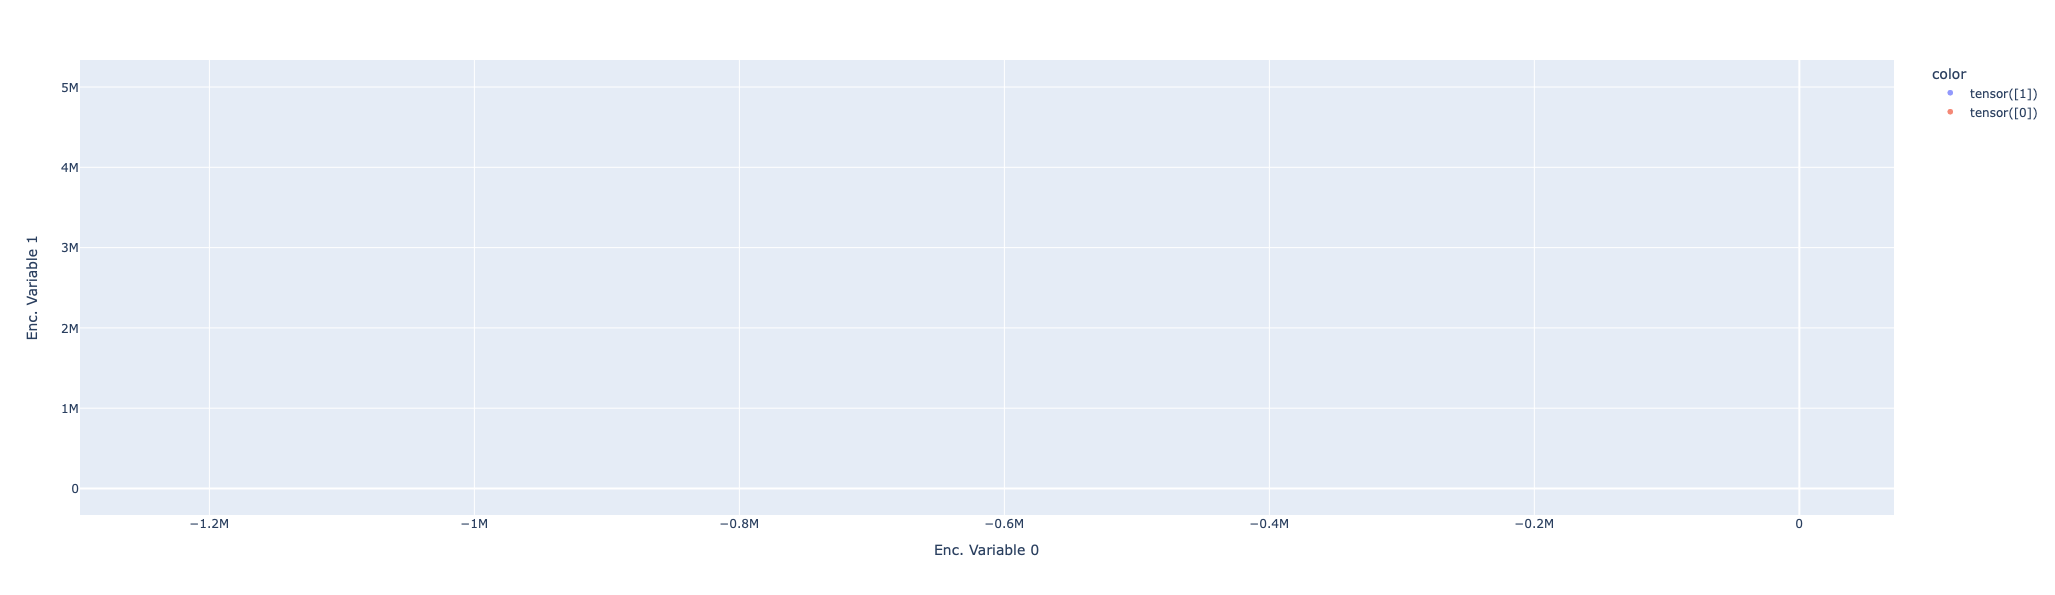

In [49]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

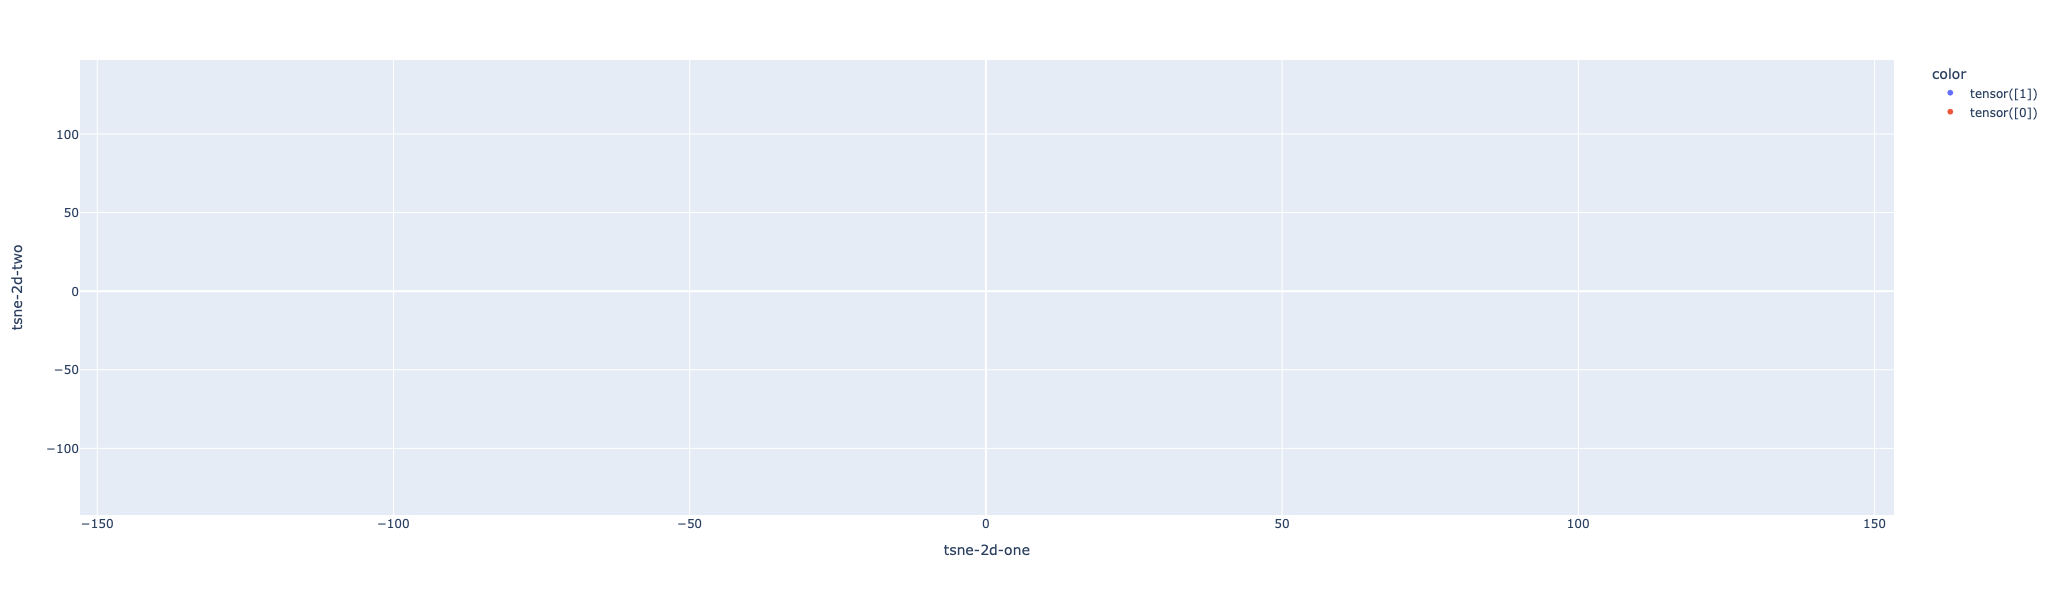

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [59]:
import kaleido
fig.write_image("fig1.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
